In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Please download your arrays

In [2]:
data_date = np.load('Keograms/date_date.npy')   #1 (doy) one dimensional (925 days)
year_arr = np.load('Keograms/year_arr.npy')      #2 (year) one dimensional (925, correspond each day)
dataset_gray_lon = np.load('Keograms/dataset_old.npy')  #3     keogram lat 3 dimensional (925, 244, 244). 925 - number of images (one day is one image) 244x244 - size of image. Images is gray color, transformed to numpy
dataset_gray_lat = np.load('Keograms/dataset_old_lat.npy')  #4 the same like 3, only lat keogram

dataset_old = np.load('Keograms/dataset_old.npy')  #don't use it
dataset_old_lat = np.load('Keograms/dataset_old_lat.npy')  #don't use it

print(data_date.shape)  # check shapes
print(year_arr.shape)
#print(dataset_gray_lon.shape)
#print(dataset_gray_lat.shape)

(925,)
(925,)


In [3]:
my_list = np.load('Keograms/my_list_new.npy')
my_list_lat = np.load('Keograms/my_list_lat_new.npy')
data_date = np.load('Keograms/new_dates.npy')
year_arr = np.load('Keograms/new_years.npy', allow_pickle=True)
dataset_old = np.load('Keograms/dataset_old_2.npy')
dataset_old_lat = np.load('Keograms/dataset_old_lat_2.npy')

In [4]:
print(year_arr.shape)

(425,)


Transform to gray color (don't use it, if already transformed)

In [5]:
from PIL import Image
import cv2


dataset_gray_lon = []
for arr in dataset_old:

  image_pil = Image.fromarray(arr)
  grays = image_pil.convert('L')
  grays = np.asarray(grays)
  grays = cv2.bitwise_not(grays)
  dataset_gray_lon.append(grays)


dataset_gray_lon = np.asarray(dataset_gray_lon)
print(dataset_gray_lon.shape)


(425, 224, 224)


In [6]:
from PIL import Image
import cv2


dataset_gray_lat = []
for arr in dataset_old_lat:

  image_pil = Image.fromarray(arr)
  grays = image_pil.convert('L')
  grays = np.asarray(grays)
  grays = cv2.bitwise_not(grays)
  dataset_gray_lat.append(grays)


dataset_gray_lat = np.asarray(dataset_gray_lat)
print(dataset_gray_lat.shape)

(425, 224, 224)


Set the PCA parameters (please variate the variance)

In [13]:
#Reshaping X to a 2D array for PCA and then k-means
XX_1 = dataset_gray_lon.reshape(-1,dataset_gray_lon.shape[1]*dataset_gray_lon.shape[2]) #We will only be using XX for clustering
XX_2 = dataset_gray_lat.reshape(-1,dataset_gray_lat.shape[1]*dataset_gray_lat.shape[2]) #We will only be using XX for clustering

XX = np.concatenate((XX_1, XX_2), axis = 1)
print(XX.shape)


# Make an instance of the Model
variance = 0.6 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present. Sometimes recommended 0.95
#pca = PCA(variance)
pca = PCA(n_components = 6)

pca.fit(XX) #fit the data according to our PCA instance
print("Number of components before PCA  = " + str(XX.shape[1]))
print("Number of components after PCA 0.95 = " + str(pca.n_components_))
#dimension reduced from 784

Clus_dataSet = pca.transform(XX)
print("Dimension of our data after PCA = " + str(Clus_dataSet.shape))

(425, 100352)
Number of components before PCA  = 100352
Number of components after PCA 0.95 = 6
Dimension of our data after PCA = (425, 6)


Check the quality of restored image (inverse PCA)

Text(0.5, 1.0, '60.0% of Variance Retained')

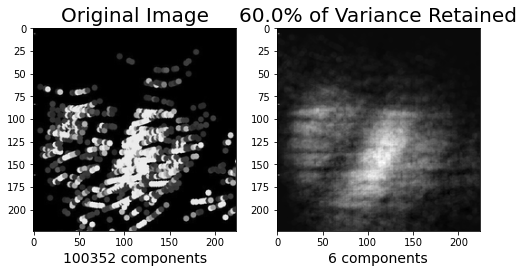

In [14]:
approximation = pca.inverse_transform(Clus_dataSet)
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4))
n = 500 #index value, change to view different data
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(XX[255,:224*224].reshape(dataset_gray_lon.shape[1], dataset_gray_lon.shape[2]),   #set the number XX[], depend on doy/year
 cmap = plt.cm.gray,);
plt.xlabel(str(XX.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);
# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[255,:224*224].reshape(dataset_gray_lon.shape[1], dataset_gray_lon.shape[2]),  #set the number XX[], depend on doy/year (same)
 cmap = plt.cm.gray,);
plt.xlabel(str(Clus_dataSet.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20)

Clustering grid

In [15]:
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.stats import skew




scaler = MinMaxScaler()



accuracy_kmeans_ecti = []
accuracy_bdv_kmeans_ecti = []


accuracy_gmm_ecti = []
accuracy_bdv_gmm_ecti = []
#y_t = Clus_dataSet.copy()
y_t = scaler.fit_transform(Clus_dataSet)

print(y_t.shape)
for n_cluster in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
  #y_t = y_t.reshape(224, 32)
  kmeans = KMeans(n_cluster, max_iter=10000, n_init=20, tol=0.0001, random_state = 42)
  gmm = GaussianMixture(n_components=n_cluster, covariance_type = 'tied', tol=1e-8,  n_init = 20, random_state = 42)

  # fitting
  kmeans.fit(y_t)
  gmm.fit(y_t)

  # prediction
  y_pred_kmeans_ecti = kmeans.predict(y_t)
  y_pred_gmm_ecti = gmm.predict(y_t)

  #metrics
  this_set = y_t.copy()
  silhouette_avg = silhouette_score(this_set, y_pred_kmeans_ecti)
  bouldin_avg = davies_bouldin_score(this_set, y_pred_kmeans_ecti)

  silhouette_avg_mm = silhouette_score(this_set, y_pred_gmm_ecti)
  bouldin_avg_mm = davies_bouldin_score(this_set, y_pred_gmm_ecti)

  accuracy_kmeans_ecti.append(silhouette_avg)
  accuracy_bdv_kmeans_ecti.append(bouldin_avg)

  accuracy_gmm_ecti.append(silhouette_avg_mm)
  accuracy_bdv_gmm_ecti.append(bouldin_avg_mm)



print(accuracy_kmeans_ecti)
print(accuracy_bdv_kmeans_ecti)

print(accuracy_gmm_ecti)
print(accuracy_bdv_gmm_ecti)

(425, 6)


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 20 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


[0.41668979140891244, 0.38004320541578784, 0.3805411186996517, 0.3911736364458273, 0.39446579493263667, 0.3915602894790523, 0.3903858709545257, 0.36581192964075865, 0.363043910534551, 0.3638175171753961, 0.3767671728706944]
[1.3361968481095925, 1.8161790147038055, 1.7198955089080852, 1.6257162557944291, 1.5174529847892424, 1.440957967414965, 1.4420647881072997, 1.3623140801858993, 1.4112634689835626, 1.3561606704536255, 1.2944777773311469]
[0.3891248340380622, 0.3976375216202918, 0.3935494213644518, 0.3941088016636642, 0.34816828243487463, 0.31155813006550515, 0.3526662725198933, 0.3664704690264368, 0.3496048353520968, 0.3587779966471453, 0.36270582594064815]
[1.417101136033574, 1.7064315315588683, 1.7280246869250901, 1.7731893933671254, 2.0988178587503974, 1.8916783649590343, 1.8243574255710622, 1.7655292080430263, 1.750102850493534, 1.4644131322318037, 1.43650313218801]


Plot the accuracy curves

Text(0.5, 0, 'Number of clusters')

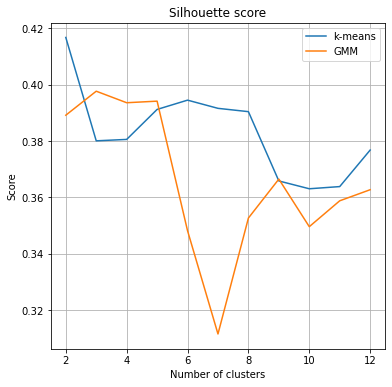

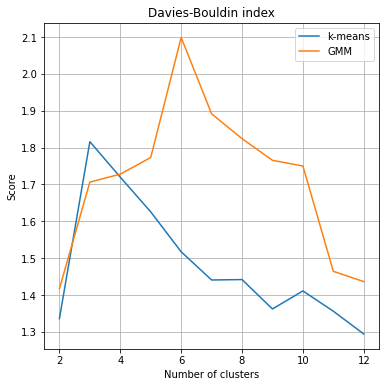

In [17]:
plt.figure(figsize = (6, 6))

x_axis = np.asarray([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])



plt.plot(x_axis, accuracy_kmeans_ecti)
plt.plot(x_axis, accuracy_gmm_ecti)
  #plt.plot(x_axis, accuracy_dim)
#plt.plot(x_axis, accuracy_gmm_ecti, linestyle = '--')
plt.grid()
plt.title('Silhouette score')
plt.legend(['k-means', 'GMM'])
plt.ylabel('Score')
plt.xlabel('Number of clusters')

plt.figure(figsize = (6, 6))

x_axis = np.asarray([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])



plt.plot(x_axis, accuracy_bdv_kmeans_ecti)
plt.plot(x_axis, accuracy_bdv_gmm_ecti)
  #plt.plot(x_axis, accuracy_dim)
#plt.plot(x_axis, accuracy_gmm_ecti, linestyle = '--')
plt.grid()
plt.title('Davies-Bouldin index')
plt.legend(['k-means', 'GMM'])
plt.ylabel('Score')
plt.xlabel('Number of clusters')

In [ ]:
#np.save('/content/drive/My Drive/Keograms/accuracy_kmeans_ecti.npy', accuracy_kmeans_ecti)
#np.save('/content/drive/My Drive/Keograms/accuracy_gmm_ecti.npy', accuracy_gmm_ecti)

#np.save('/content/drive/My Drive/Keograms/accuracy_bdv_kmeans_ecti.npy', accuracy_bdv_kmeans_ecti)
#np.save('/content/drive/My Drive/Keograms/accuracy_bdv_gmm_ecti.npy', accuracy_bdv_gmm_ecti)

Check with the classification task (XGBoost)

Visualisation of results

In [11]:
#set the numbers of types
gmm = GaussianMixture(n_components=3, covariance_type = 'tied', n_init = 20, random_state = 42) #choose one of this algorithm and set the found from optimization number of clusters
kmeans = KMeans(n_clusters = 3, max_iter=10000, n_init=20, tol=0.0001, random_state = 42) #or this

X = y_t.copy()
y = gmm.fit_predict(y_t)  #change gmm to kmeans, if prefer kmeans

y_pred_kmeans = y.copy()

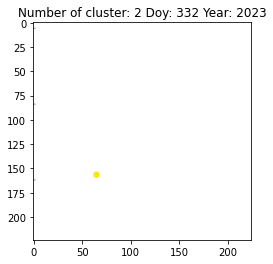

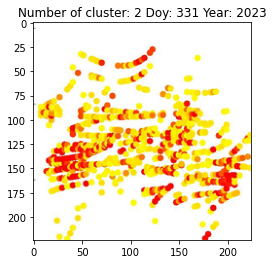

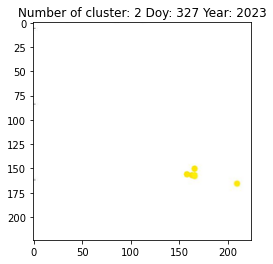

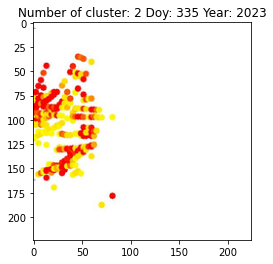

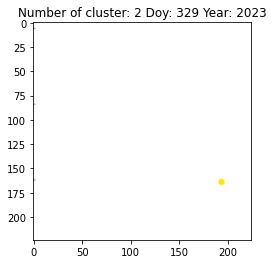

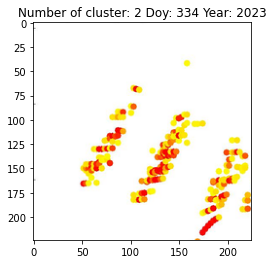

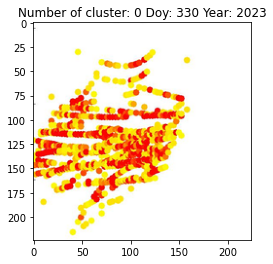

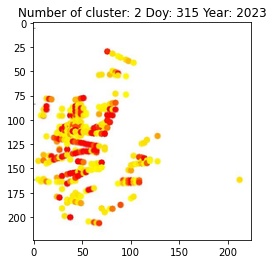

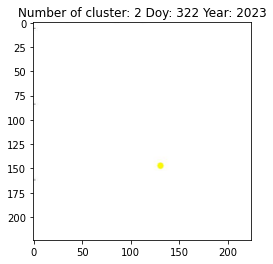

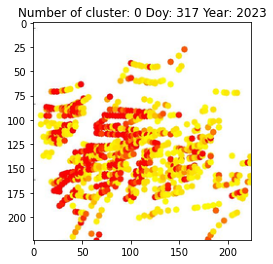

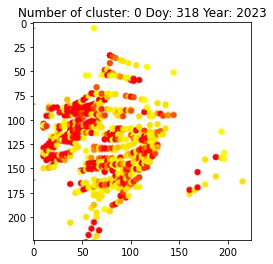

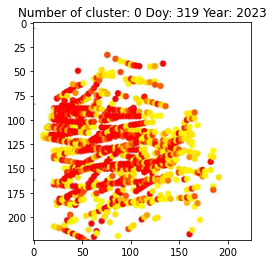

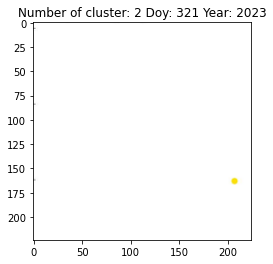

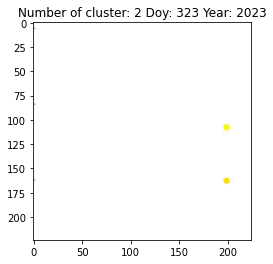

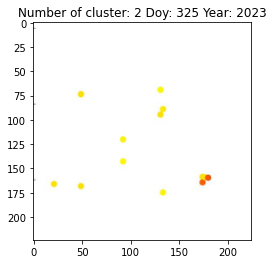

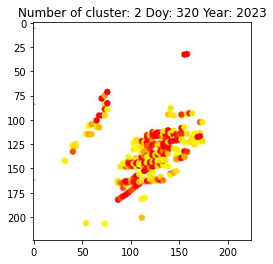

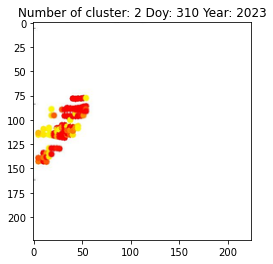

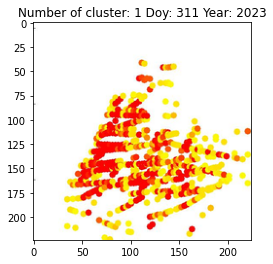

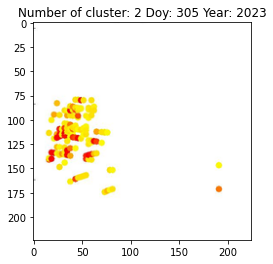

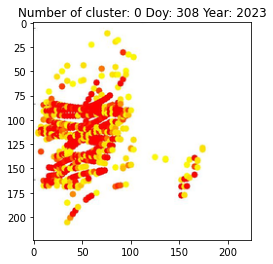

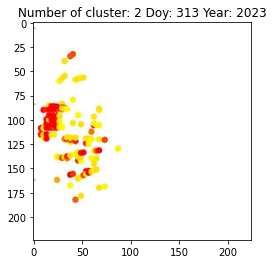

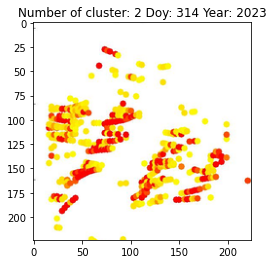

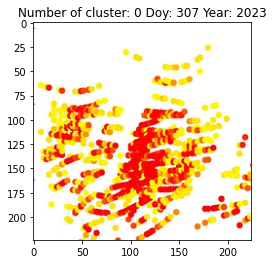

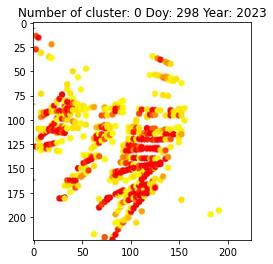

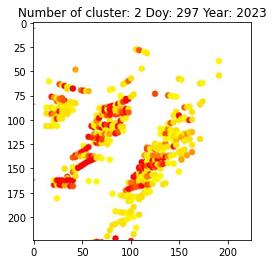

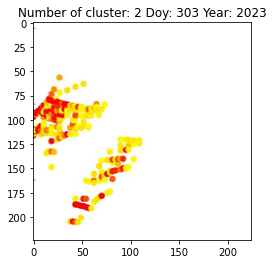

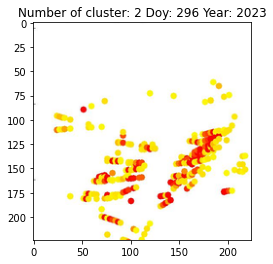

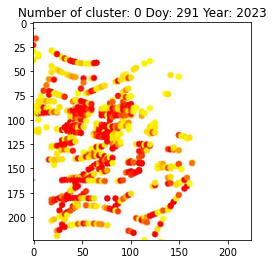

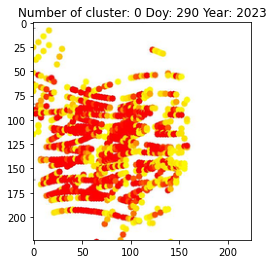

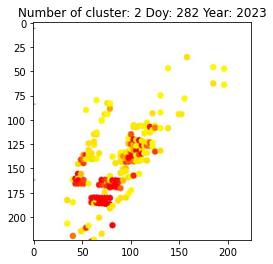

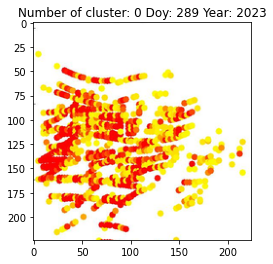

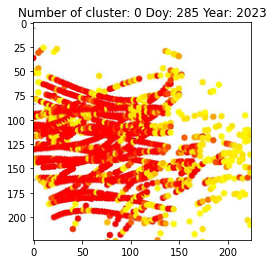

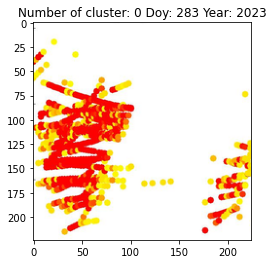

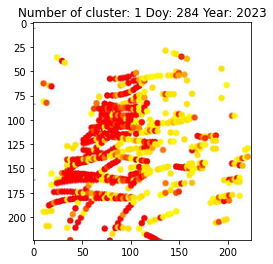

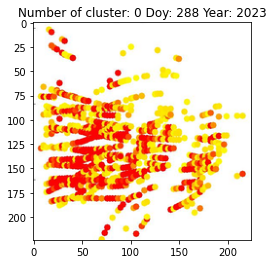

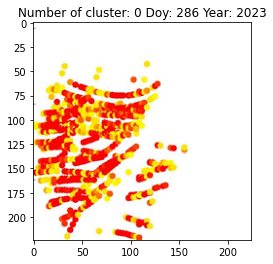

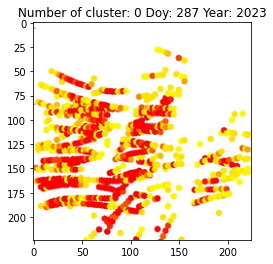

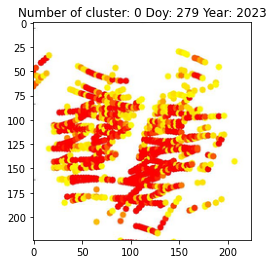

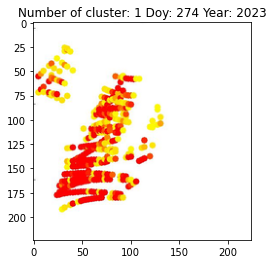

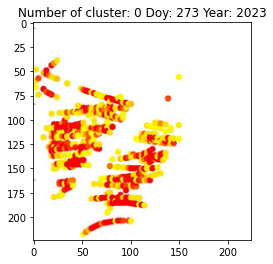

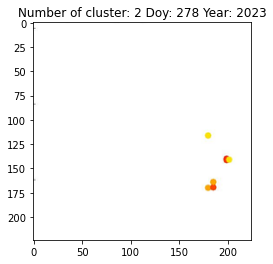

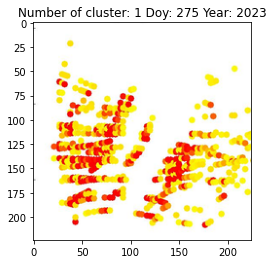

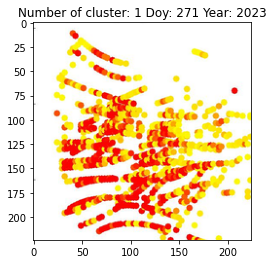

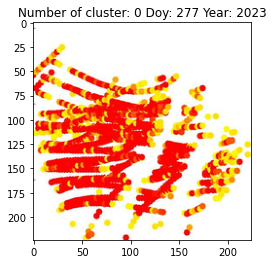

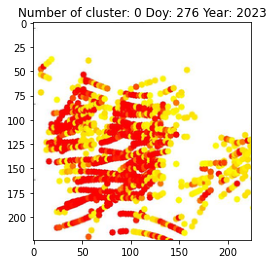

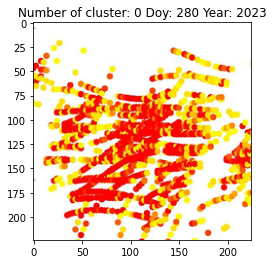

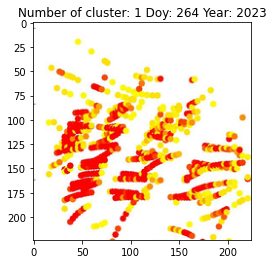

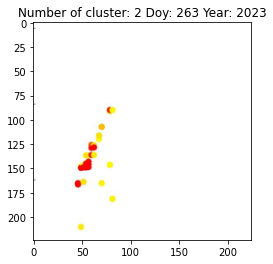

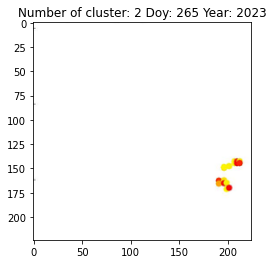

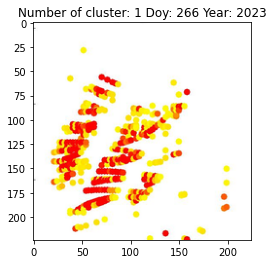

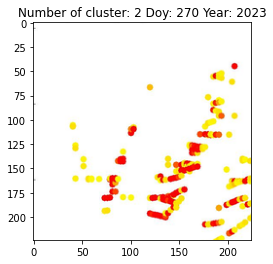

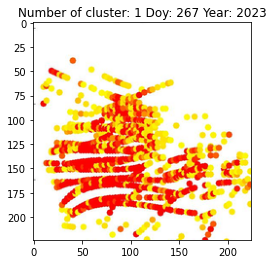

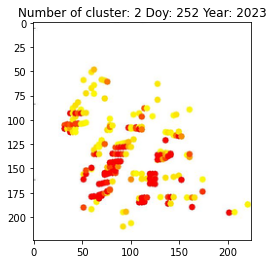

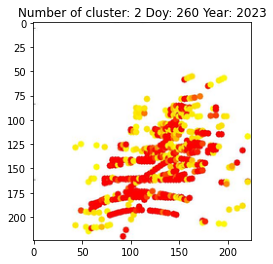

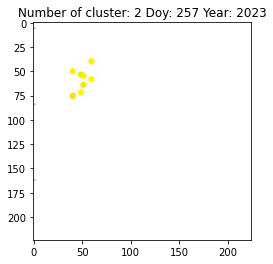

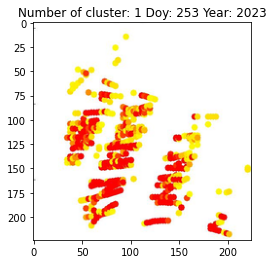

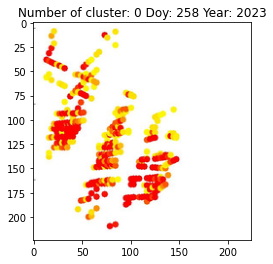

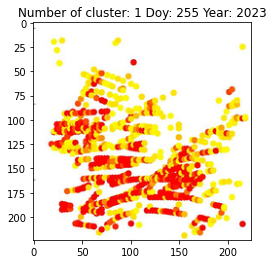

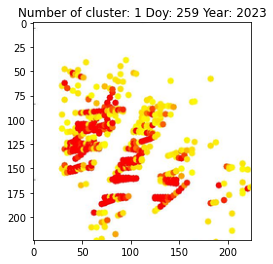

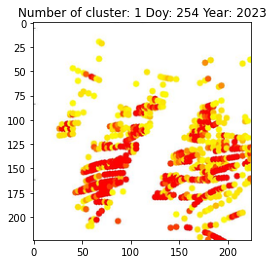

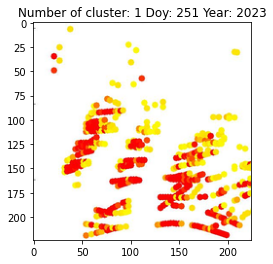

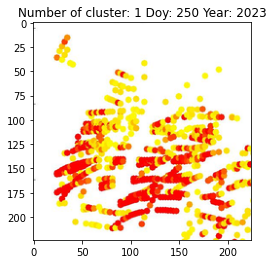

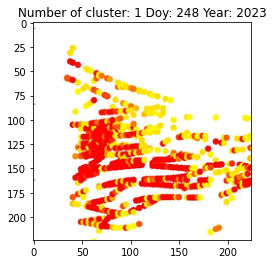

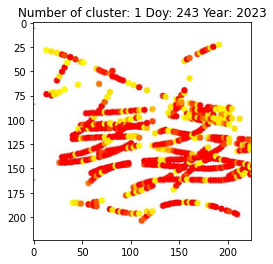

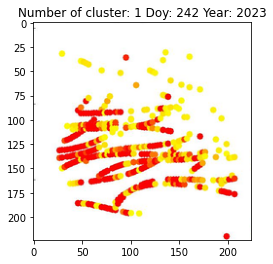

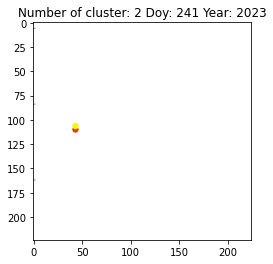

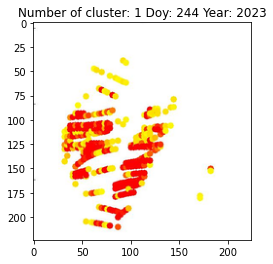

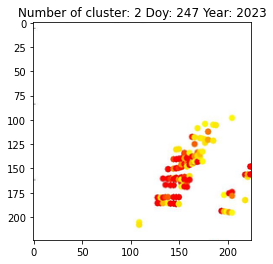

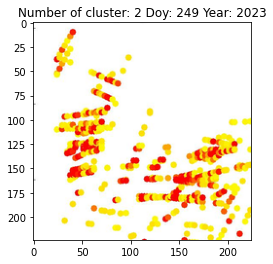

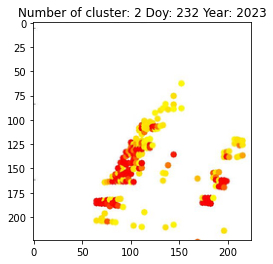

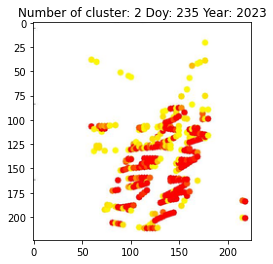

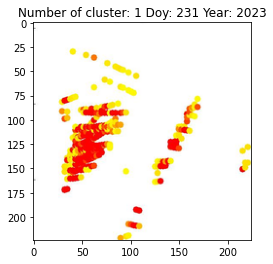

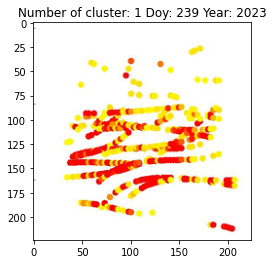

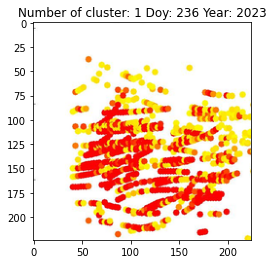

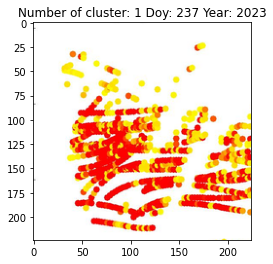

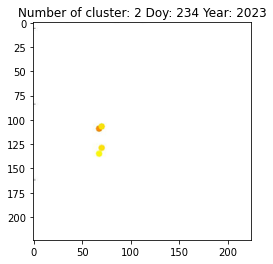

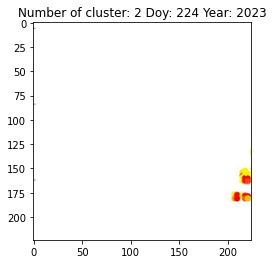

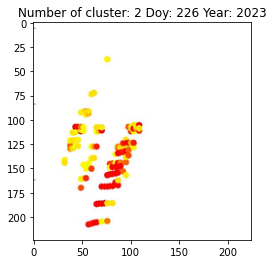

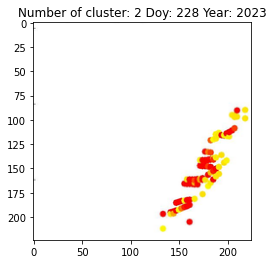

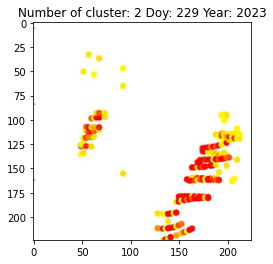

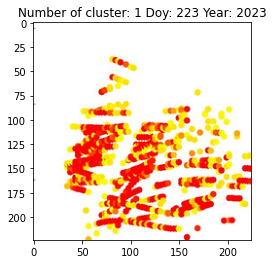

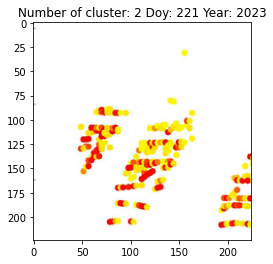

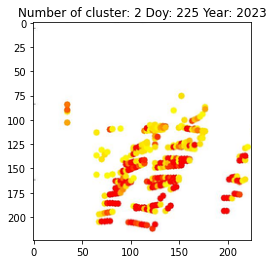

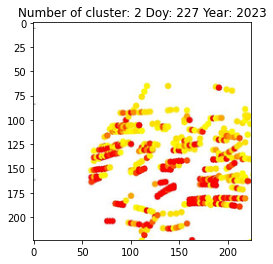

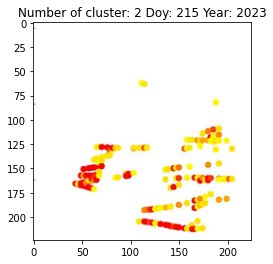

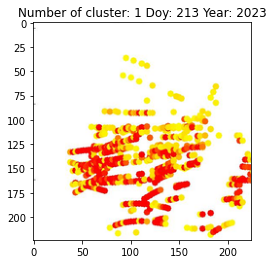

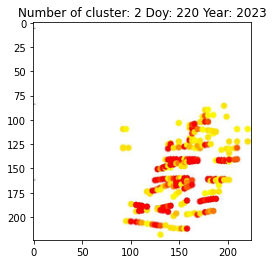

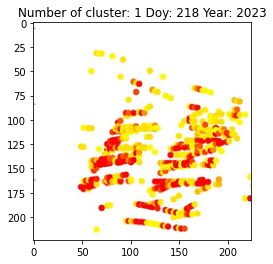

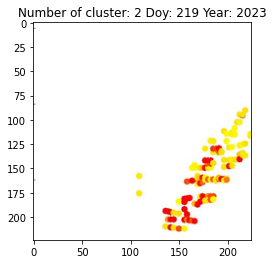

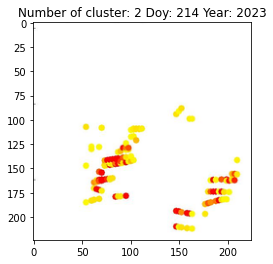

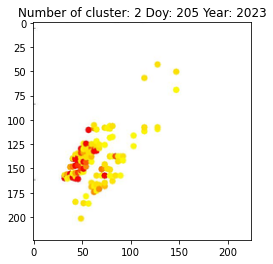

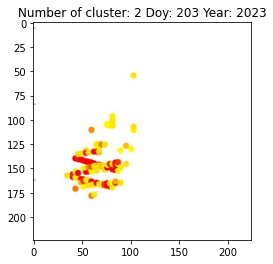

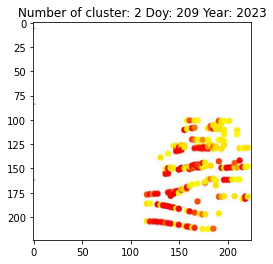

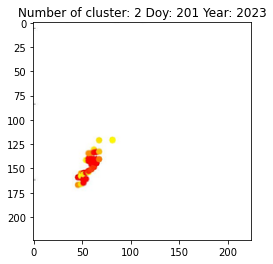

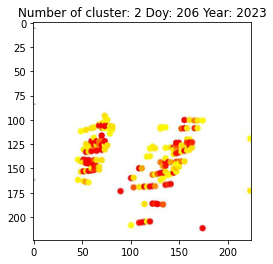

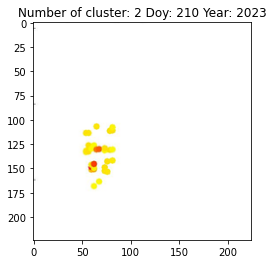

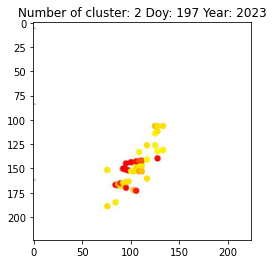

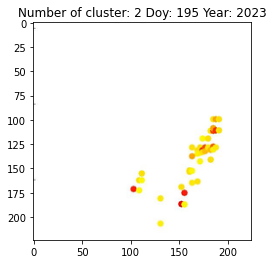

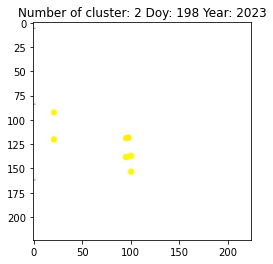

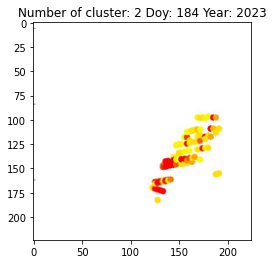

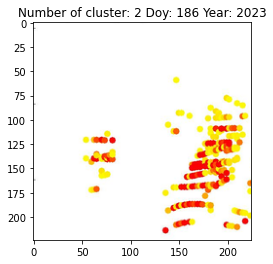

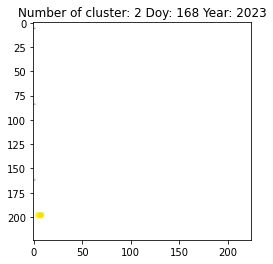

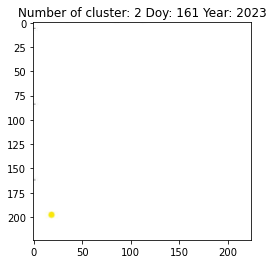

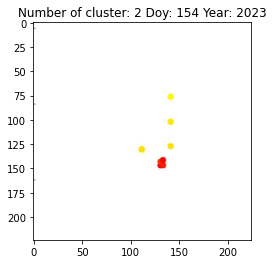

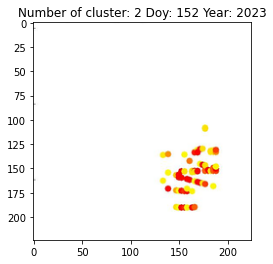

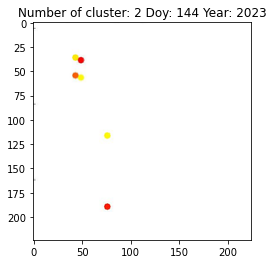

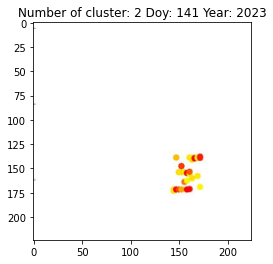

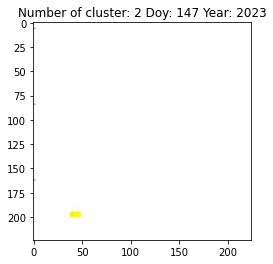

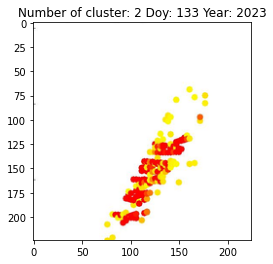

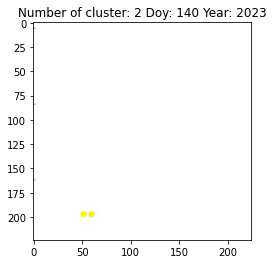

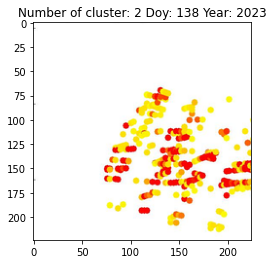

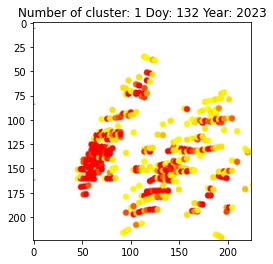

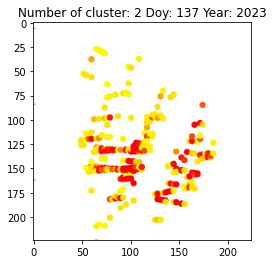

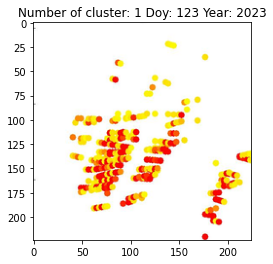

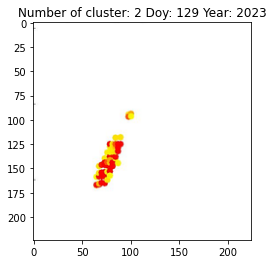

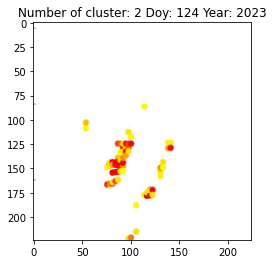

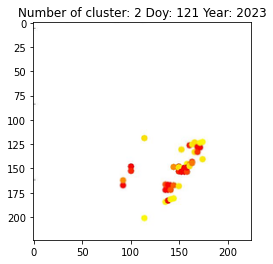

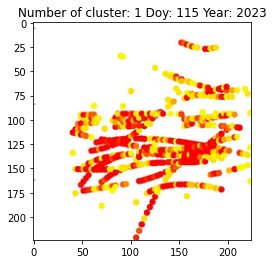

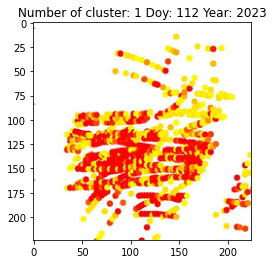

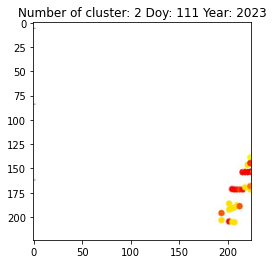

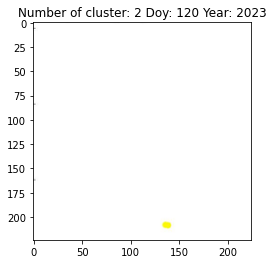

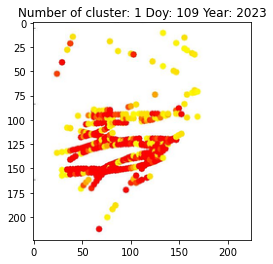

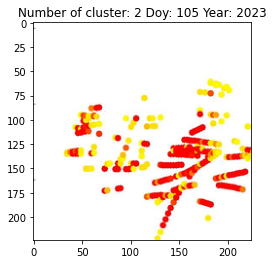

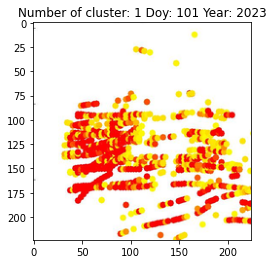

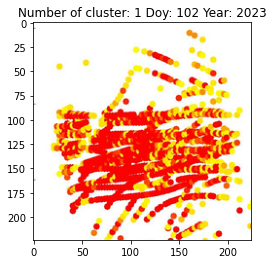

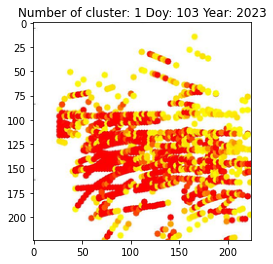

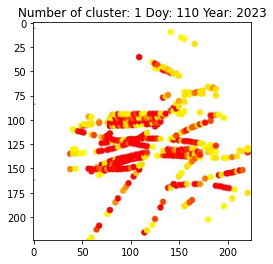

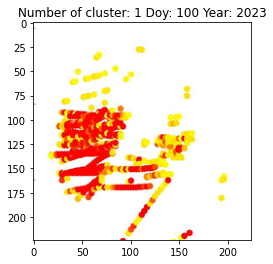

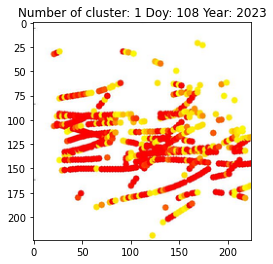

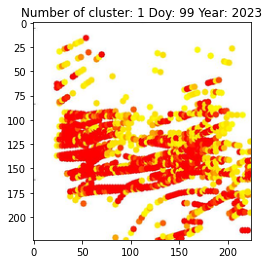

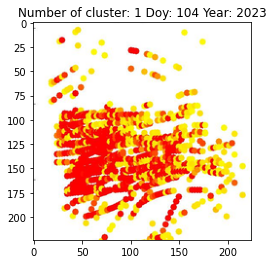

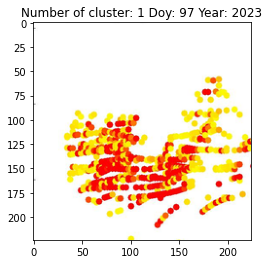

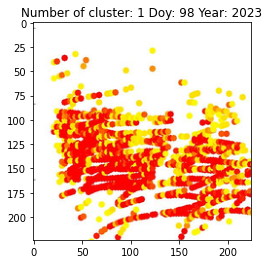

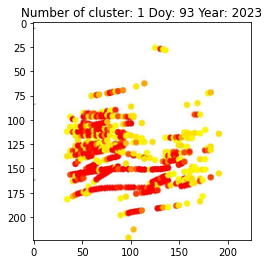

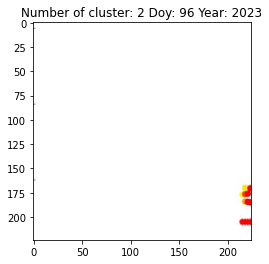

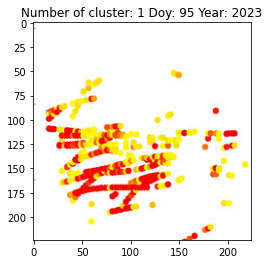

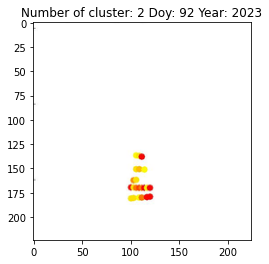

In [ ]:
labels = y_pred_kmeans.copy()
counter_0 = 0
counter_1 = 0
counter_2 = 0
counter_3 = 0
counter_4 = 0

for i in range(425):

  if year_arr[i] == '2023':

    plt.imshow(dataset_old[i, :, :])
    str_title = 'Number of cluster: ' + str(labels[i]) + ' Doy: ' + str(data_date[i]) + ' Year: ' + str(year_arr[i])
    plt.title(str_title)
    plt.show()
    if labels[i] == 0:
      counter_0 += 1
    if labels[i] == 1:
      counter_1 += 1
    if labels[i] == 2:
      counter_2 += 1
    if labels[i] == 3:
      counter_3 += 1
    if y_pred_kmeans[i] == 4:
      counter_4 += 1


  #print('Number of graph keogram', i)